# Anomaly Detection - EECS 731 Assignment # 06
---

In [1]:
%%time

# Import all module as per requirement
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from  datetime import datetime as dt

# Render out plots inline
%matplotlib inline

# Importing the models as per requirement
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

CPU times: user 1.38 s, sys: 456 ms, total: 1.83 s
Wall time: 2.74 s


## Dataset Loading into Data Frame
---
I have chosen the **Machine Temperature System Failure** dataset for this assignment. As usual, we are first loading the dataset csv file *(mts_failure.csv)* into the dataframe, followed by head based inspection. The dataset description indicates that there are 3 anomalies in the given data, where one is easier as compared to other two anomalies.

In [2]:
anomalyDF = pd.read_csv ('../data/machine_temperature_system_failure.csv', parse_dates = ['timestamp'], dtype = {'value': np.float32}, encoding = 'UTF-8')
anomalyDF.head ()

,timestamp,value
0,2013-12-02 21:15:00,73.967323
1,2013-12-02 21:20:00,74.935883
2,2013-12-02 21:25:00,76.124161
3,2013-12-02 21:30:00,78.140709
4,2013-12-02 21:35:00,79.329834


Next, we inspect and **visualize** the timeline analysis graph for the given data.

Text(0.5, 1.0, 'Trend of Values over Time')

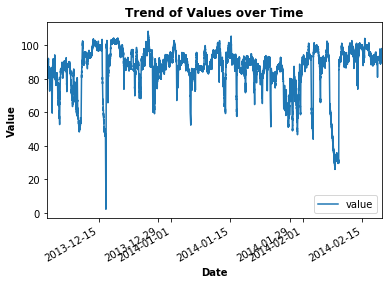

In [3]:
anomalyDF.plot (y = 'value', x = 'timestamp')
plt.ylabel ('Value', fontweight = 'bold')
plt.xlabel ('Date', fontweight = 'bold')
plt.title ('Trend of Values over Time', fontweight='bold' )

As we can see in the above timeline graph, we have **three anomalies**; one occuring at the beginning and much easier to detect. On the other hand, it is challenging to detect remaining two anomalies occuring at the right end of the graph. These two anomalies are harder to detect as they are very near to the normal values.

## Analysis # 01 - Value Change over Time
---
Here, we analyze the change in the **VALUE** as the time progresses. We also **drop any NaN values** before proceeding for the analysis.

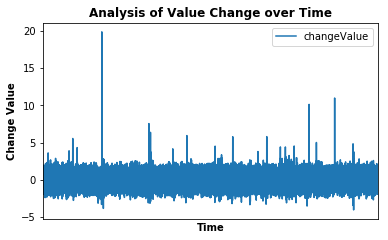

In [4]:
anomalyDF ['changeValue'] = anomalyDF ['value'] - anomalyDF ['value'].shift (1)
anomalyDF.plot (y = 'changeValue', x = 'timestamp')
anomalyDF = anomalyDF.dropna ()

#plotting the CHANGE VALUE ANALYSIS
plt.xticks ([])
plt.ylabel ('Change Value', fontweight = 'bold')
plt.xlabel ('Time', fontweight = 'bold')
plt.title ('Analysis of Value Change over Time', fontweight = 'bold')
plt.show ()

## Analysis # 02 - Exponentially Weighted Moving Average (EMWA) of Data

In this analysis, we calculate the exponenetially weighted moving average (on window size of 05) to get more insights locally into the smaller regions of the timeline.

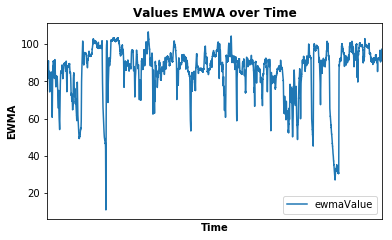

In [6]:
anomalyDF ['ewmaValue'] = anomalyDF ['value'].ewm (com = 5).mean ()
anomalyDF.plot (y = 'ewmaValue', x = 'timestamp')

# Plotting the EMWA Analysis
plt.xticks ([])
plt.ylabel ('EWMA', fontweight = 'bold')
plt.xlabel ('Time', fontweight = 'bold')
plt.title ('Values EMWA over Time', fontweight = 'bold')
plt.show ()

These EMWA values are not providing any meaningful insights, so skipping them for next steps.

## Anomaly Detection # 01 - One Class SVM Based
---

First, we model the anomaly detection problem using One Class SVM model.

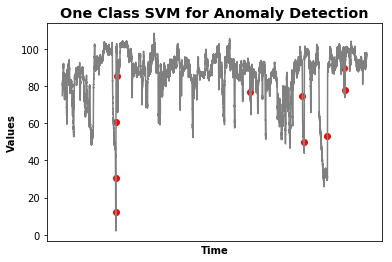

CPU times: user 748 ms, sys: 245 ms, total: 994 ms
Wall time: 517 ms


In [9]:
%%time
#initializing the One Class SVM
OneClassSVMModel = OneClassSVM(nu = (0.0005), gamma = 0.00025)
OneClassSVMModel.fit (anomalyDF [['changeValue']])
anomalyDF ['anomaly'] = pd.Series (OneClassSVMModel.predict(anomalyDF [['changeValue']]))
anomalyDF ['anomaly'] = anomalyDF ['anomaly'].map( {1: 0, -1: 1} )

# Now Visualizing the anomaly detection model for its effeciveness...
fig, ax = plt.subplots ()
a = anomalyDF.loc [anomalyDF ['anomaly'] == 1, ['timestamp', 'value']]
ax.plot (list (anomalyDF ['timestamp']), list (anomalyDF ['value']), color = 'grey')
ax.scatter (list (a ['timestamp']), list (a ['value']), color = 'red', lw = 1)
plt.title ('One Class SVM for Anomaly Detection', fontweight = 'bold', fontsize = 'x-large')
plt.ylabel ('Values', fontweight = 'bold')
plt.xlabel ('Time', fontweight = 'bold')
plt.xticks ([])
plt.yticks ()
plt.show ()

As shown above, One Class SVM based anomaly detection algorithm worked very efficiently, but lacked the accuracy as it was incorrectly detecting other normal instances as anomalies as indicated by the red dots.

## Anomaly Detection # 02 - Isolation Forest Based
---
Next, we analyze the Isolation Forest based Algorithm for the given anomaly detection problem.

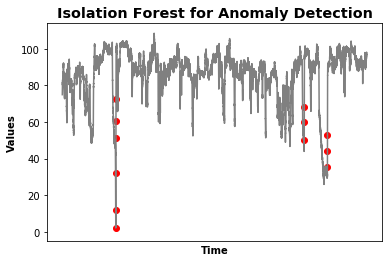

CPU times: user 2.01 s, sys: 177 ms, total: 2.19 s
Wall time: 1.88 s


In [12]:
%%time
IsolationForestModel = IsolationForest(contamination=0.0005, behaviour="new", random_state=1)
IsolationForestModel.fit(anomalyDF [['changeValue']])
anomalyDF ['anomaly'] = pd.Series (IsolationForestModel.predict(anomalyDF [['changeValue']]))
anomalyDF ['anomaly'] = anomalyDF ['anomaly'].map( {1: 0, -1: 1} )

# Now Visualizing to analyze our anomaly detection Isolation Forest model Performance
fig, ax = plt.subplots ()
a = anomalyDF.loc [anomalyDF ['anomaly'] == 1, ['timestamp', 'value']]
ax.plot (list (anomalyDF ['timestamp']), list (anomalyDF ['value']), color = 'grey')
ax.scatter (list (a ['timestamp']), list (a ['value']), color = 'red', lw = 1)

plt.title ('Isolation Forest for Anomaly Detection', fontweight = 'bold', fontsize = 'x-large')
plt.ylabel ('Values', fontweight = 'bold')
plt.xlabel ('Time', fontweight = 'bold')
plt.xticks ([])
plt.yticks ()
plt.show ()

Isolation Forest is not very efficient as compared to the Once class SVM, but it proved to be much more effective than One class SVM algorithm.

# Conclusion

Anomaly detection is a unique problem, as normal classification or regression based approaches are not applicable directly on this type of problem, because of the imbalanced nature of the data. In this assignment, we analyzed two anomaly detection algorithms, namely **One Class SVM** and **Isolation Forest Algorithm**. One class SVM was proved to be much faster and efficent, but Isolation Forest based model gave much effective results but slower in processing. So, we can use either of them based on the requirement (e.g Real Time processing reuiqred or not etc.).